In [1]:
import requests
import numpy as np
import cv2
import base64
import json
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

In [7]:
import numpy as np
import cv2
import json
import requests

def infer_image(image_path: str, triton_url: str, model_name: str, input_name: str, output_name: str) -> np.ndarray:
    """
    Performs inference on an image using a Triton server.

    Args:
        image_path (str): Path to the image.
        triton_url (str): URL of the Triton server.
        model_name (str): Name of the model in Triton.
        input_name (str): Name of the input tensor in Triton.
        output_name (str): Name of the output tensor in Triton.

    Returns:
        np.ndarray: Results of the inference.
    """
    # Load the image
    img = cv2.imread(image_path)

    # Preprocess the image
    img = img / 255.0
    img = cv2.resize(img, (256, 256))
    h, w = img.shape[:2]
    y0 = (h - 224) // 2
    x0 = (w - 224) // 2
    img = img[y0:y0 + 224, x0:x0 + 224, :]
    img = (img - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
    img = np.transpose(img, axes=[2, 0, 1])
    img = img.astype(np.float32)
    img = np.expand_dims(img, axis=0)

    # Flatten the image for the payload
    img_flatten = img.flatten()

    # Create the payload for the request
    data = {
        "inputs": [
            {
                "name": input_name,
                "shape": list(img.shape),
                "datatype": "FP32",
                "data": img_flatten.tolist()
            }
        ],
        "outputs": [
            {
                "name": output_name
            }
        ]
    }

    inference_json = json.dumps(data)

    # Send the request to Triton
    response = requests.post(f"{triton_url}/v2/models/{model_name}/infer", data=inference_json)

    # Check the response
    if response.status_code != 200:
        raise Exception(f"Error during request: {response.text}")

    # Get the results
    result = np.array(response.json()['outputs'][0]['data'])

    return result

In [14]:
# Ejemplo de uso
image_path = 'images/kitten.jpg'
triton_url = 'http://10.30.248.75:9084'
model_name = 'resnet'
input_name = 'INPUT__0'
output_name = 'OUTPUT__0'
results_number = 3

In [15]:
import numpy as np

# Usage
result = infer_image(image_path, triton_url, model_name, input_name, output_name)

# Get the indices of the top N predictions
indices = np.argpartition(result, -results_number)[-results_number:]
# Retrieve the top N predictions using the indices
top_n_predictions = result[indices]

snow leopard, ounce, Panthera uncia --- prob: 8.692046
tiger cat --- prob: 8.940369
lynx, catamount --- prob: 9.420026


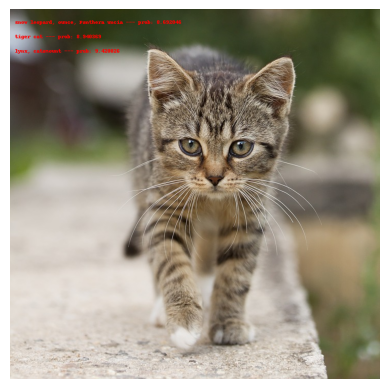

In [16]:
# Load the model's labels from the archive
with open('synset.txt', 'r') as f:
    labels = [l.rstrip() for l in f]

# Print the results
for i in range(results_number):
    text = '%s --- prob: %f' %(labels[indices[i]][10:],top_n_predictions[i])
    print(text)

# Load the image
image = Image.open(image_path)

# Create a drawing context
draw = ImageDraw.Draw(image)

# Define font and text
font = ImageFont.load_default()

for i in range(results_number):
    text = '%s --- prob: %f' %(labels[indices[i]][10:],top_n_predictions[i])
    draw.text((10, 20 + i*28), text, font=font, fill='red')

plt.imshow(image)
plt.axis('off')
plt.show()
